In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg' # For mac users with Retina display

import numpy as np
import matplotlib.pyplot as plt
import sys, random
sys.path.append('/Users/fbianchini/Research/FlatSpec/')
from Spec2D import *
from Sims import *
from scipy.integrate import simps
from astropy.io import fits

from read_cats import GetSDSSCat
from maps import Skymap, Healpixmap

from cosmojo.utils import nl_cmb, bl


In [11]:
arcmin2rad = np.pi / 180. / 60. 


def GetCutout(pixmap, pixcent, npix):
    """
    Extracts a cutout of size (npix,npix) centered in (pixcent[0], pixcent[1]) from a bigger map pixmap
    """
    x, y = pixcent
    x, y = np.int(x), np.int(y)
    return pixmap[y-npix:y+npix+1, x-npix:x+npix+1]

def GoGetStack(x, y, skymap, mask, npix):
    results = {}
    results['maps'] = []
    
    for i in xrange(len(x)):
        cutmask = GetCutout(mask, (x[i],y[i]), npix=npix)
#         print cutmask.shape
        isgood = True if (np.mean(cutmask) == 1) & (cutmask.shape == (2*npix+1,2*npix+1)) else False # Do analysis if all the cutout within the footprint

#         print x[i], y[i], isgood, np.mean(cutmask)

        if isgood: # Cutout is *completely* in the footprint
            results['maps'].append(GetCutout(skymap, (x[i],y[i]), npix=npix))
        else: # discard object
            pass

    results['maps'] = np.asarray(results['maps'])			
    
    return results

def twoD_Gaussian((x, y), amplitude, xo, yo, sigma_x=1, sigma_y=1, theta=0., offset=0):
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) + c*((y-yo)**2)))
    return g#.ravel()

def Add2dGauss(x, y, data, npix, amp=5.):
    for i in xrange(len(x)):
        X, Y = np.meshgrid(np.arange(y[i]-npix, y[i]+npix+1), np.arange(x[i]-npix, x[i]+npix+1))
#         X -= x[i]
#         Y -= y[i]
#         plt.imshow(twoD_Gaussian((X,Y), amplitude=amp, xo=x[i], yo=y[i]))
        try:
            data[y[i]-npix:y[i]+npix+1, x[i]-npix:x[i]+npix+1] += twoD_Gaussian((Y,X), amplitude=amp, xo=x[i], yo=y[i], sigma_x=1, sigma_y=1)
#             plt.imshow(twoD_Gaussian((Y,X), amplitude=amp, xo=x[i], yo=y[i], sigma_x=1, sigma_y=1))
        except:
#             print sys.exc_info()
            pass
    return data

def FilterMap(pixmap, lmin, lmax, reso, pad=1):
    if pad !=1:
        pixmap = np.pad(pixmap, ((pixmap.shape[0], pixmap.shape[0])), mode='constant', constant_values=0.)
    
    ft = np.fft.fftshift(np.fft.fft2(pixmap))
    mask = GetLMask(pixmap.shape[0], dx=reso, lmin=lmin, lmax=lmax, shift=True)
    
    return np.fft.ifft2(np.fft.fftshift(ft*mask)).real
    
def GetLMask(nx, dx, ny=None, dy=None, shift=False, lmin=None, lmax=None, lxmin=None, lxmax=None, lymin=None, lymax=None):
    """ 
    return a Fourier mask for the pixelization associated with this object which is zero over customizable ranges of L. 
    """
    if ny == None: ny = nx
    mask      = np.ones((ny, nx), dtype=np.complex)
    lx, ly    = GetLxLy(nx, dx, ny=ny, dy=dy, shift=shift)
    L         = GetL(nx, dx, dy=dy, ny=ny, shift=shift)
    if lmin  != None: mask[ np.where(L < lmin) ] = 0.0
    if lmax  != None: mask[ np.where(L >=lmax) ] = 0.0
    if lxmin != None: mask[ np.where(np.abs(lx) < lxmin) ] = 0.0
    if lymin != None: mask[ np.where(np.abs(ly) < lymin) ] = 0.0
    if lxmax != None: mask[ np.where(np.abs(lx) >=lxmax) ] = 0.0
    if lymax != None: mask[ np.where(np.abs(ly) >=lymax) ] = 0.0

    return mask

def GetLxLy(nx, dx, ny=None, dy=None, shift=True):
    """ 
    Returns two grids with the (lx, ly) pair associated with each Fourier mode in the map. 
    If shift=True (default), \ell = 0 is centered in the grid
    ~ Note: already multiplied by 2\pi 
    """
    if ny is None: ny = nx
    if dy is None: dy = dx
    
    dx *= arcmin2rad
    dy *= arcmin2rad
    
    if shift:
        return np.meshgrid( np.fft.fftshift(np.fft.fftfreq(nx, dx))*2.*np.pi, np.fft.fftshift(np.fft.fftfreq(ny, dy))*2.*np.pi )
    else:
        return np.meshgrid( np.fft.fftfreq(nx, dx)*2.*np.pi, np.fft.fftfreq(ny, dy)*2.*np.pi )


def GetL(nx, dx, ny=None, dy=None, shift=True):
    """ 
    Returns a grid with the wavenumber l = \sqrt(lx**2 + ly**2) for each Fourier mode in the map. 
    If shift=True (default), \ell = 0 is centered in the grid
    """
    lx, ly = GetLxLy(nx, dx, ny=ny, dy=dy, shift=shift)
    return np.sqrt(lx**2 + ly**2)

def GetACTbeam(nx, dx, dy=None, ny=None, shift=True, filepath='/Users/fbianchini/Documents/beams_AR2_2010_season_130224.dat.txt'):
    """ 
    Returns 2D FT of ACT beam.
    If shift=True (default), \ell = 0 is centered in the grid
    """
    if ny is None: ny = nx
    if dy is None: dy = dx
 
    l, bl = np.loadtxt(filepath, unpack=True)
    L = GetL(nx, dx, ny=ny, dy=dy, shift=shift)
    idx = np.where(L > 20000)
    xx = np.interp(L, l, bl)
    xx[idx] = 0.
#     plt.semilogy(l,bl)
    return xx

def Get2dSpectra(pixmap, dx, dy=None, shift=True):
    ny, nx = pixmap.shape
    if dy is None: 
        dy = dx
    dx *= arcmin2rad
    dy *= arcmin2rad

    if shift:
        ft = np.fft.fftshift(np.fft.fft2(pixmap))
    else:
        ft = np.fft.fft2(pixmap)
    return np.abs(ft)# * (dx*dy)/(nx*ny)

def MatchFilter(pixmap, dx, dy=None, beam='ACT', lmin=None, lmax=None, lxmin=None, lxmax=None, lymin=None, lymax=None, shift=True):
    ny, nx = pixmap.shape

    # Anisotropic filter
    F = GetLMask(nx, dx, dy=dy, ny=ny, shift=shift, lmin=lmin, lmax=lmax, lxmin=lxmin, lxmax=lxmax, lymin=lymin, lymax=lymax)
    
#     plt.matshow(np.abs(F))
    
    # Beam
    if beam == 'ACT':
        B = GetACTbeam(nx, dx, ny=ny, shift=shift)
#         plt.matshow(np.abs(B))
        print beam
    elif beam == 0.:
        B = np.ones_like(F)
    elif beam > 0.:
        B = make_2d_gaussian_beam(nx, dx, beam, shift=shift)
    
    T = Get2dSpectra(pixmap, dx, dy=dy, shift=shift)
    T2_inv = np.nan_to_num(1./np.abs(T))**2
    print T2_inv.shape, B.shape, F.shape
    BFTB = np.conj(B) * F * T2_inv * B #reduce(np.dot, [np.conj(B), F, T2_inv, B])
    integral = 1.#/simps(simps(BFTB, x=GetLxLy(nx, dx, dy=dy, ny=ny)[1][:,0]), x=GetLxLy(nx, dx, dy=dy, ny=ny)[0][0,:])

    return np.nan_to_num(F * np.conj(B) * T2_inv) / integral #reduce(np.dot, [F, B, T2_inv]) / integral 

def MatchFilterMap(pixmap, dx, dy=None, ny=None, beam=0., lmin=None, lmax=None, lxmin=None, lxmax=None, lymin=None, lymax=None, shift=False, pad=2):
    ny, nx = pixmap.shape
    
#     mask = smooth_window(np.ones_like(pixmap),ker_size=16)
    
#     fac = np.mean(mask**2)
    
#     pixmap *= mask/fac
    
    if pad !=1:
        pixmap = np.pad(pixmap, ((pixmap.shape[1]/2, pixmap.shape[0]/2)), mode='constant', constant_values=0.)
        
    print pixmap.shape
        
    mf = MatchFilter(pixmap, dx, dy=dy, beam=beam, shift=shift, lmin=lmin, lmax=lmax, lxmin=lxmin, lxmax=lxmax, lymin=lymin, lymax=lymax)
    
    result = np.fft.ifft2(np.fft.fft2(pixmap)*mf).real
    
    if pad != 1:
        result = extract(result, nx, ny)
    return result

#     mf = MatchFilter(pixmap, dx, dy=dy, beam=beam, shift=shift, lmin=lmin, lmax=lmax, lxmin=lxmin, lxmax=lxmax, lymin=lymin, lymax=lymax)
#     return np.fft.ifft2(np.fft.fft2(pixmap)*mf).real

def make_2d_gaussian_beam(nx, dx, fwhm, shift=True):
    """Already in L-space"""
    L = GetL(nx, dx, shift=shift)
    idx = np.where(L > 20000)

    B_l = bl(fwhm, L.max())

    xx = np.interp(L, np.arange(B_l.size), B_l)
    xx[idx] = 0.

    return xx

def Bin2D(ft, dx, ny=None, dy=None, lbins=np.linspace(2,10000, 100)):
    ny, nx = ft.shape
    L = GetL(nx, dx, ny=ny, dy=dy, shift=True)
    nbins = len(lbins) - 1
    ell_bins = np.asarray([[lbins[i], lbins[i+1]] for i in xrange(nbins)])
    
    av_cls, bins     = np.histogram(L, bins=lbins, weights=ft)
    av_weights, bins = np.histogram(L, bins=lbins, weights=np.ones_like(ft))

    # Azimuthal-average of 2D spectrum
    cl  = np.nan_to_num(av_cls / av_weights)
    lb  = np.mean(ell_bins, axis=1)

    return lb, cl.real

def extract(p, nx, ny):
    padx = (p.shape[1]-nx)/2
    pady = (p.shape[0]-ny)/2
    return p[pady:pady+ny, padx:padx+nx]


In [4]:
tmap = fits.open('/Volumes/LACIE_SHARE/Data/ACT/ACT_220_equ_season_3_1way_v3_src_free.fits')
hits = fits.open('/Volumes/LACIE_SHARE/Data/ACT/ACT_220_equ_season_3_1way_hits_v3.fits')     
tmap_weighted = np.sqrt(hits[0].data[:,:17500])*tmap[0].data[:,:17500]/np.sum(np.sqrt(hits[0].data[:,:17500])) 
tmap_not_weighted = tmap[0].data[:,:17500]

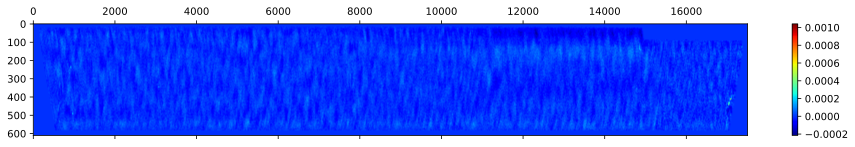

In [5]:
# Map "weighted" with hits (see Marsden+14, sec.3)
plt.matshow(tmap_weighted, aspect='auto', cmap='jet');plt.colorbar()

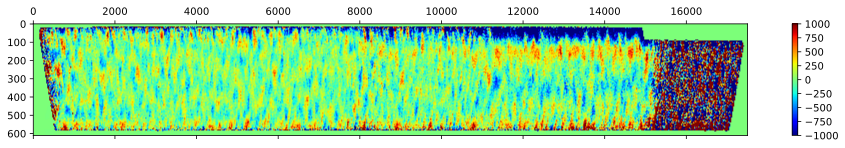

In [6]:
# Raw map
plt.matshow(tmap[0].data[:,:17500], aspect='auto', vmin=-1000, vmax=1000, cmap='jet');plt.colorbar()

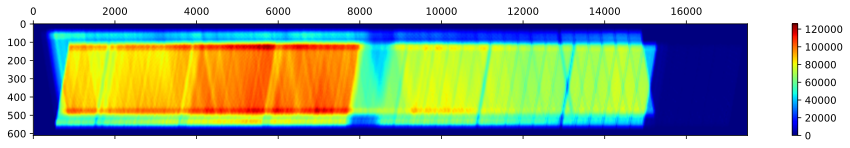

In [7]:
# Hits map
plt.matshow(hits[0].data[:,:17500], aspect='auto', cmap='jet');plt.colorbar()

In [8]:
# Some parameters ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
nrnd = 200000

nu = 220

# Redshift bins
zbins = [(1.,2.15), (2.15,2.50),(2.50,5.0)]

# Reading in QSO catalogs
qso_cat = GetSDSSCat(cats=['DR7', 'DR12'], discard_FIRST=True, z_DR12='Z_PIPE') # path_cats

# ACT/ACTpol channels
nus = [220]

# Cutouts (half-)size in pixels 
npix    = {148:10,
           220:10}  # ACTpol pixels are ~ 30 arcsec, cutouts are 10'x10' 

# Beam @ different freq 
psf     = {148: 1.4*60.,
           220: 1.4*60.} # arcsec

factor  = {140: 1.,
           220: 1.} # \muK/pix -> mJy/beam

# Pixel resolution
reso    = {148: 30.,
           220: 30.} # arcsec

positions = {148: (10.5, 10.5),
             220: (10.5, 10.5)}

# boxsize = {250:51, 350:39, 500:27}
# boxsize    = {250:101, 350:77, 500:51} # SPIRE pixels are ~ 6/8/12 arcsec -> cutouts are 5'
# positions = {250: (101/2., 101/2.), 350: (77/2.,77/2.), 500:(51/2.,51/2.)}

# H-ATLAS patches
patches = ['G9', 'G12', 'G15']#, 'NGP', 'SGP']


In [9]:
# Fits files
fmap = '/Volumes/LACIE_SHARE/Data/ACT/ACT_220_equ_season_3_1way_v3_src_free.fits'
fmask = '/Volumes/LACIE_SHARE/Data/ACT/ACT_220_equ_season_3_1way_hits_v3.fits'
fnoise = None#data_path + 'ACT/ACTPol_'+str(nu)+'_D56_PA2_S2_1way_noise.fits'



In [12]:
# ANALYSIS ON FILTERED MAPS (weighted by hits)
fluxmap = Skymap(fmap, psf[nu], fnoise=fnoise, fmask=fmask, color_correction=1.0)

print('Filtering map')
fluxmap.map = MatchFilterMap(tmap_weighted, 0.5, lmin=1000, lxmin=100, beam='ACT')
print('Done')

mask = fits.open(fmask)
mask = mask[0].data
mask[mask < 70000.] = 0.
mask[(mask >= 70000)] = 1.

# print("\t...the mean of the map is : %.5f Jy/beam" %(np.mean(fluxmap.map[np.where(fluxmap.mask == 1.)])))
results_filtered = {}

# Loop over redshift bins
for idz, (zmin, zmax) in enumerate(zbins):
    print("\t...z-bin : " + str(zmin) + " < z < " + str(zmax))
    qso = qso_cat[(qso_cat.Z >= zmin) & (qso_cat.Z <= zmax)]
    # print len(qso)

    # Remember that x refers to axis=0 and y refers to axis=1 -> MAP[y,x]
    x, y = fluxmap.w.wcs_world2pix(qso.RA, qso.DEC, 0) # 0 because numpy arrays start from 0
    good_idx = (~np.isnan(x)) & (~np.isnan(y))
    x = x[good_idx]
    y = y[good_idx]

    results_filtered[idz] = GoGetStack(x, y, fluxmap.map, mask, npix[nu])

    # Saving stuff
    results_filtered[idz]['nu'] = nu
    results_filtered[idz]['zbin'] = (zmin, zmax)


Filtering map
(9666, 26555)
ACT
(9666, 26555) (9666, 26555) (9666, 26555)
Done
	...z-bin : 1.0 < z < 2.15


/Users/fbianchini/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


	...z-bin : 2.15 < z < 2.5
	...z-bin : 2.5 < z < 5.0


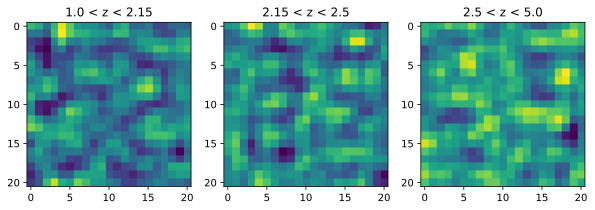

In [13]:
# filtered stack
plt.figure(figsize=(10,4))
for idz, (zmin,zmax) in enumerate(zbins):
    plt.subplot(1,3,idz+1)
    plt.title(str(zmin) + ' < z < '+ str(zmax))
    plt.imshow(results_filtered[idz]['maps'].mean(0))#; plt.colorbar()

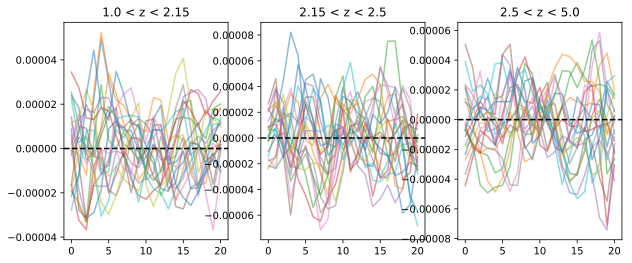

In [14]:
# Slices through filtered stack
plt.figure(figsize=(10,4))
for idz, (zmin,zmax) in enumerate(zbins):
    plt.subplot(1,3,idz+1)
    plt.title(str(zmin) + ' < z < '+ str(zmax))
    for i in xrange(results_filtered[idz]['maps'].mean(0).shape[0]):
        plt.plot(results_filtered[idz]['maps'].mean(0)[i,:], alpha=0.5)
    plt.axhline(ls='--', color='k')

In [15]:
# ANALYSIS ON UN-FILTERED MAPS (weighted by hits)
fluxmap = Skymap(fmap, psf[nu], fnoise=fnoise, fmask=fmask, color_correction=1.0)

fluxmap.map = tmap_weighted#MatchFilterMap(tmap_weighted, 0.5, lmin=1000, lxmin=100, beam='ACT')

mask = fits.open(fmask)
mask = mask[0].data
mask[mask < 70000.] = 0.
mask[(mask >= 70000)] = 1.

# print("\t...the mean of the map is : %.5f Jy/beam" %(np.mean(fluxmap.map[np.where(fluxmap.mask == 1.)])))
results_unfiltered = {}

# Loop over redshift bins
for idz, (zmin, zmax) in enumerate(zbins):
    print("\t...z-bin : " + str(zmin) + " < z < " + str(zmax))
    qso = qso_cat[(qso_cat.Z >= zmin) & (qso_cat.Z <= zmax)]
    # print len(qso)

    # Remember that x refers to axis=0 and y refers to axis=1 -> MAP[y,x]
    x, y = fluxmap.w.wcs_world2pix(qso.RA, qso.DEC, 0) # 0 because numpy arrays start from 0
    good_idx = (~np.isnan(x)) & (~np.isnan(y))
    x = x[good_idx]
    y = y[good_idx]

    results_unfiltered[idz] = GoGetStack(x, y, fluxmap.map, mask, npix[nu])

    # Saving stuff
    results_unfiltered[idz]['nu'] = nu
    results_unfiltered[idz]['zbin'] = (zmin, zmax)


	...z-bin : 1.0 < z < 2.15
	...z-bin : 2.15 < z < 2.5
	...z-bin : 2.5 < z < 5.0


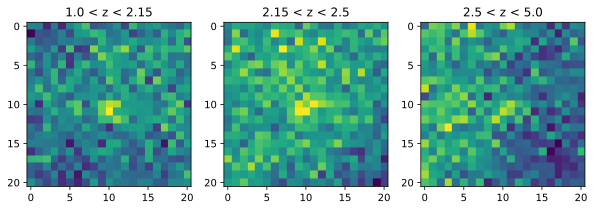

In [16]:
plt.figure(figsize=(10,4))
for idz, (zmin,zmax) in enumerate(zbins):
    plt.subplot(1,3,idz+1)
    plt.title(str(zmin) + ' < z < '+ str(zmax))
    plt.imshow(results_unfiltered[idz]['maps'].mean(0))#; plt.colorbar()

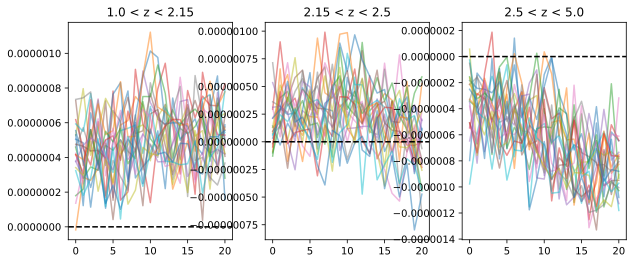

In [17]:
plt.figure(figsize=(10,4))
for idz, (zmin,zmax) in enumerate(zbins):
    plt.subplot(1,3,idz+1)
    plt.title(str(zmin) + ' < z < '+ str(zmax))
    for i in xrange(results_unfiltered[idz]['maps'].mean(0).shape[0]):
        plt.plot(results_unfiltered[idz]['maps'].mean(0)[i,:], alpha=0.5)
    plt.axhline(ls='--', color='k')


ACT
(611, 17500) (611, 17500) (611, 17500)


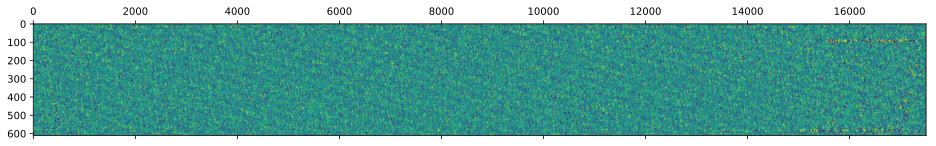

In [109]:
plt.matshow(MatchFilterMap(tmap_not_weighted, 0.5, beam='ACT', lmin=1000, lxmin=100), aspect='auto', vmin=-3e-10, vmax=3e-10)

ACT
(611, 17500) (611, 17500) (611, 17500)


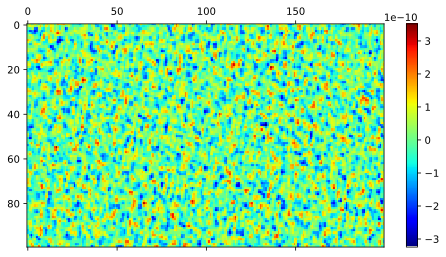

In [108]:
plt.matshow(MatchFilterMap(tmap_not_weighted, 0.5, beam='ACT', lmin=1000, lxmin=100)[300:400,4000:4200], aspect='auto',cmap='jet'); plt.colorbar()#, vmin=-1, vmax=1, cmap='jet')

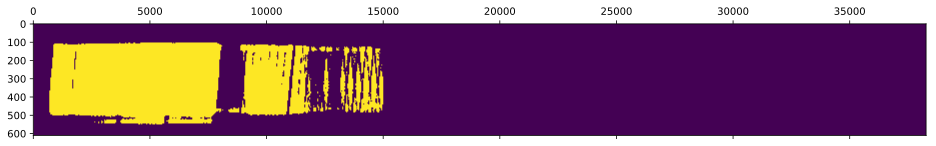

In [81]:
plt.matshow(mask, aspect='auto')

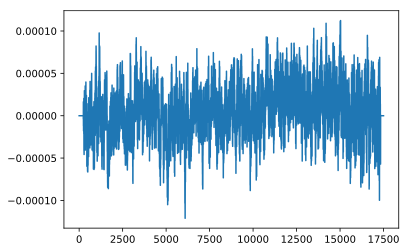

In [84]:
plt.plot(tmap_weighted[200,:])

In [18]:
mf = MatchFilter(tmap_not_weighted, 0.5, beam='ACT', lmin=1000, lxmin=100, shift=True)

ACT
(611, 17500) (611, 17500) (611, 17500)


In [19]:
lx, ly = GetLxLy(tmap_not_weighted.shape[1], 0.5, ny=tmap_not_weighted.shape[0])

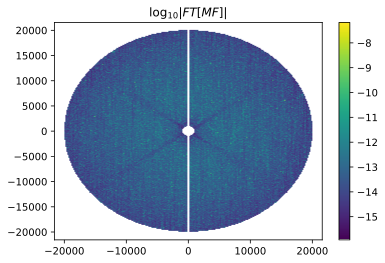

In [20]:
plt.title(r'$\log_{10}|FT[MF]|$')
plt.imshow(np.log10(np.abs(mf)), extent=[lx.min(), lx.max(), ly.min(), ly.max()], aspect='auto'); plt.colorbar()

In [21]:
l, cl = Bin2D(np.abs(mf), 0.5, lbins=np.linspace(2,20000,50))

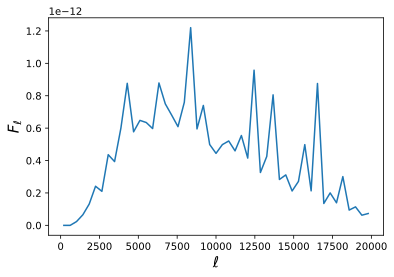

In [22]:
plt.plot(l, cl)
plt.xlabel(r'$\ell$', size=15)
plt.ylabel(r'$F_{\ell}$', size=15)